In [72]:
import os, cv2, glob, random
import numpy                     as np
import tensorflow                as tf
import matplotlib.pyplot         as plt
from keras.callbacks         import EarlyStopping
from sklearn.model_selection import train_test_split

print("Num TPUs Available: ", len(tf.config.list_physical_devices('TPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num TPUs Available:  0
Num GPUs Available:  0
Num CPUs Available:  1


In [73]:
# DATASET_PATH = "./datasets/ds_v2"
# DATASET_PATH_TEST_IMAGE = "./datasets/ds_v2/A/mpoetza1.pgm"
DATASET_PATH = "./datasets/ds_v4/All_Nums"
DATASET_PATH_TEST_IMAGE = "./datasets/ds_v4/All_Nums/3/0c3ff922-7744-40e5-8fe9-10dcbc5dca3c.rgb_0000.png"

# MODEL_PATH = "./models/model_v2.keras"
MODEL_PATH = "./models/model_v4-3.keras"

# QUANTIZED_MODEL_PATH = "./models/quant_model_v2.tflite"
QUANTIZED_MODEL_PATH = "./models/quant_model_v4-3.tflite"

# HEX_MODEL_PATH = "./models/hex_model_v2.cc"
HEX_MODEL_PATH = "./models/hex_model_v4-3.cc"

# LIST_OF_GESTURES = ['A', 'B', "Blank", "Five", "One", "Three", "Two"] # ds_v2
LIST_OF_GESTURES = ['1', '2', '3', '4', '5', '7', "Blank"] # ds_v4

Para colab

In [74]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cp -r "/content/drive/MyDrive/datasets/dataset_v4.1.zip" "dataset_v4.1.zip"
# %unzip "content/drive/MyDrive/datasets/dataset_v4.1.zip" -d .
# %clear && ls

# DATASET_PATH = './dataset_v4.1'

# MODELO DE REGRESIÓN LINEAL

## Pre procesamiento

Final dataset:
* Dataset 1: https://www.idiap.ch/webarchives/sites/www.idiap.ch/resource/gestures/ (finalmente no se uso)
* Dataset 2: https://www.kaggle.com/datasets/lexset/synthetic-asl-numbers

In [75]:
dataset_path = os.path.join(DATASET_PATH, '*')
dataset_path = glob.glob(dataset_path)
dataset_path

['./datasets/ds_v4/All_Nums/Blank',
 './datasets/ds_v4/All_Nums/1',
 './datasets/ds_v4/All_Nums/5',
 './datasets/ds_v4/All_Nums/2',
 './datasets/ds_v4/All_Nums/3',
 './datasets/ds_v4/All_Nums/7',
 './datasets/ds_v4/All_Nums/4']

Verificar el dataset

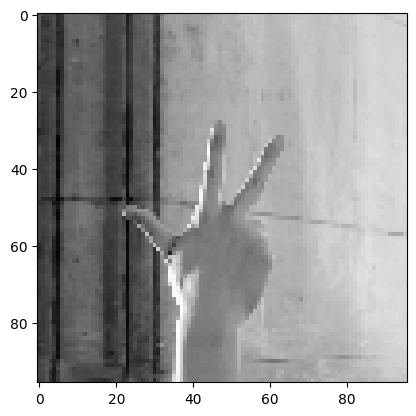

In [76]:
image = cv2.imread(DATASET_PATH_TEST_IMAGE)
image = cv2.resize(image,(96, 96))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

Pre procesamiento

In [77]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

def apply_augmentation(X_train, y_train, augmentation_fraction=0.5):
    num_images = int(len(X_train) * augmentation_fraction)
    random_indices = random.sample(range(len(X_train)), num_images)

    augmented_images = []
    augmented_labels = []

    for index in random_indices:
        image = X_train[index].reshape((1, 96, 96, 1))
        label = y_train[index]

        for aug_image in datagen.flow(image, batch_size=1):
            augmented_images.append(aug_image[0])
            augmented_labels.append(label)
            break

    X_augmented = np.asarray(augmented_images)
    y_augmented = np.asarray(augmented_labels)

    X_train_augmented = np.concatenate((X_train, X_augmented), axis=0)
    y_train_augmented = np.concatenate((y_train, y_augmented), axis=0)

    return X_train_augmented, y_train_augmented

In [78]:
loaded_images = []
outputVectors = []

for gesture_index, gesture in enumerate(LIST_OF_GESTURES):
    dataset_path = f"{DATASET_PATH}/{gesture}"
    gesture_path = os.path.join(dataset_path, '*')
    gest_path = glob.glob(gesture_path)

    for image_path in gest_path:
        image = cv2.imread(image_path)
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image, (96, 96))
            loaded_images.append(gray_image)
            outputVector = [0] * len(LIST_OF_GESTURES)
            outputVector[gesture_index] = 1
            outputVectors.append(outputVector)

print(f"Número total de imágenes cargadas: {len(loaded_images)}")
print(f"Número total de vectores de salida: {len(outputVectors)}\n")

X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 96, 96, 1)
X_test = X_test.reshape(X_test.shape[0], 96, 96, 1)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}\n")

X_train_augmented, y_train_augmented = apply_augmentation(X_train, y_train, augmentation_fraction=0.3)
X_test_augmented, y_test_augmented = apply_augmentation(X_test, y_test, augmentation_fraction=0.3)

print(f"Forma de X_train después de augmentation: {X_train_augmented.shape}")
print(f"Forma de y_train después de augmentation: {y_train_augmented.shape}")
print(f"Forma de X_test después de augmentation: {X_test_augmented.shape}")
print(f"Forma de y_test después de augmentation: {y_test_augmented.shape}")

Número total de imágenes cargadas: 7000
Número total de vectores de salida: 7000

Forma de X: (7000, 96, 96)
Forma de y: (7000, 7)

Forma de X_train: (5600, 96, 96, 1)
Forma de X_test: (1400, 96, 96, 1)
Forma de y_train: (5600, 7)
Forma de y_test: (1400, 7)

Forma de X_train después de augmentation: (7280, 96, 96, 1)
Forma de y_train después de augmentation: (7280, 7)
Forma de X_test después de augmentation: (1820, 96, 96, 1)
Forma de y_test después de augmentation: (1820, 7)


## CNN Model

In [ ]:
model = tf.keras.Sequential([
    # tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1)),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # tf.keras.layers.Dropout(0.05),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # tf.keras.layers.Dropout(0.05),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # tf.keras.layers.Dropout(0.05),
    # tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # tf.keras.layers.Dropout(0.05),
    # tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # tf.keras.layers.Dropout(0.05),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(384, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(192, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.05),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')

    tf.keras.layers.Conv2D(filters=14, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=56, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # tf.keras.layers.Dense(72, activation='relu'),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/benja/Documents/University_studies/Proyecto_de_Desarrollo_de_Software_ICC4201/pds3/model_preparation/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 94, 94, 15)     │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 47, 47, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 45, 45, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 22, 22, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 20, 20, 30)     │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 10, 10, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 8, 8, 60)       │        16,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 4, 4, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 90)             │        86,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │           637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,747 (452.14 KB)

 Trainable params: 115,747 (452.14 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [96]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_augmented, y_train_augmented,
          batch_size=128,
          epochs=200,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping_callback])

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.1603 - loss: 1.7639 - val_accuracy: 0.4036 - val_loss: 0.3752
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.3298 - loss: 0.3901 - val_accuracy: 0.6000 - val_loss: 0.2896
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4937 - loss: 0.3304 - val_accuracy: 0.7086 - val_loss: 0.2311
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6080 - loss: 0.2776 - val_accuracy: 0.7836 - val_loss: 0.1850
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6604 - loss: 0.2485 - val_accuracy: 0.8271 - val_loss: 0.1525
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7107 - loss: 0.2142 - val_accuracy: 0.8364 - val_loss: 0.1373
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7437 - loss: 0.1885 - val_accuracy: 0.8521 - val_loss: 0.1301
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.7709 - loss: 0.1719 - val_accu

Guardar

In [97]:
model.save(MODEL_PATH)

## Información

Evaluar el modelo

In [98]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))
model.summary()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9207 - loss: 0.0765
Accuracy: 0.9264285564422607


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 94, 94, 15)     │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 47, 47, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 45, 45, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 22, 22, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 20, 20, 30)     │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 10, 10, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 8, 8, 60)       │        16,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 4, 4, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 90)             │        86,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │           637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,243 (1.32 MB)

 Trainable params: 115,747 (452.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 231,496 (904.29 KB)

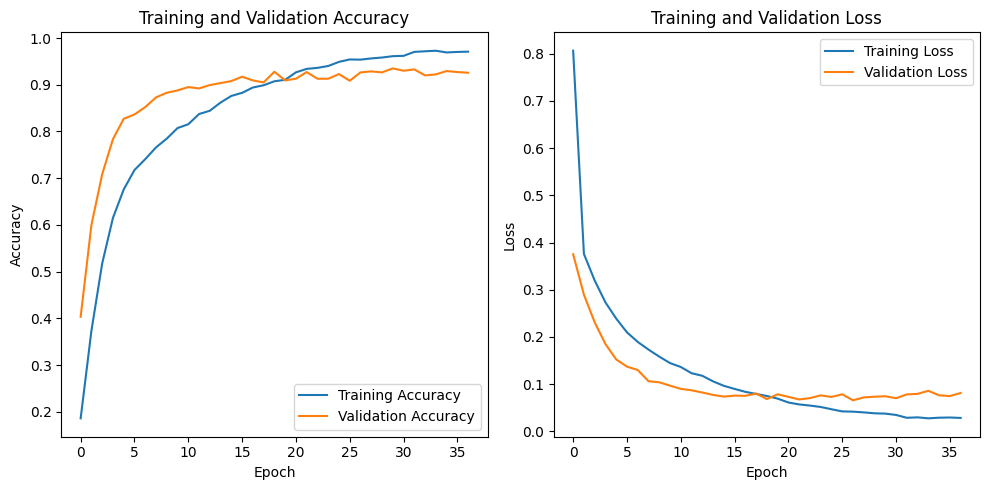

In [99]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

## Predicciones del modelo

In [100]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))
print("Testing Accuracy:", acc)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9207 - loss: 0.0765
Accuracy: 0.9264285564422607
Testing Accuracy: 0.9264285564422607


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


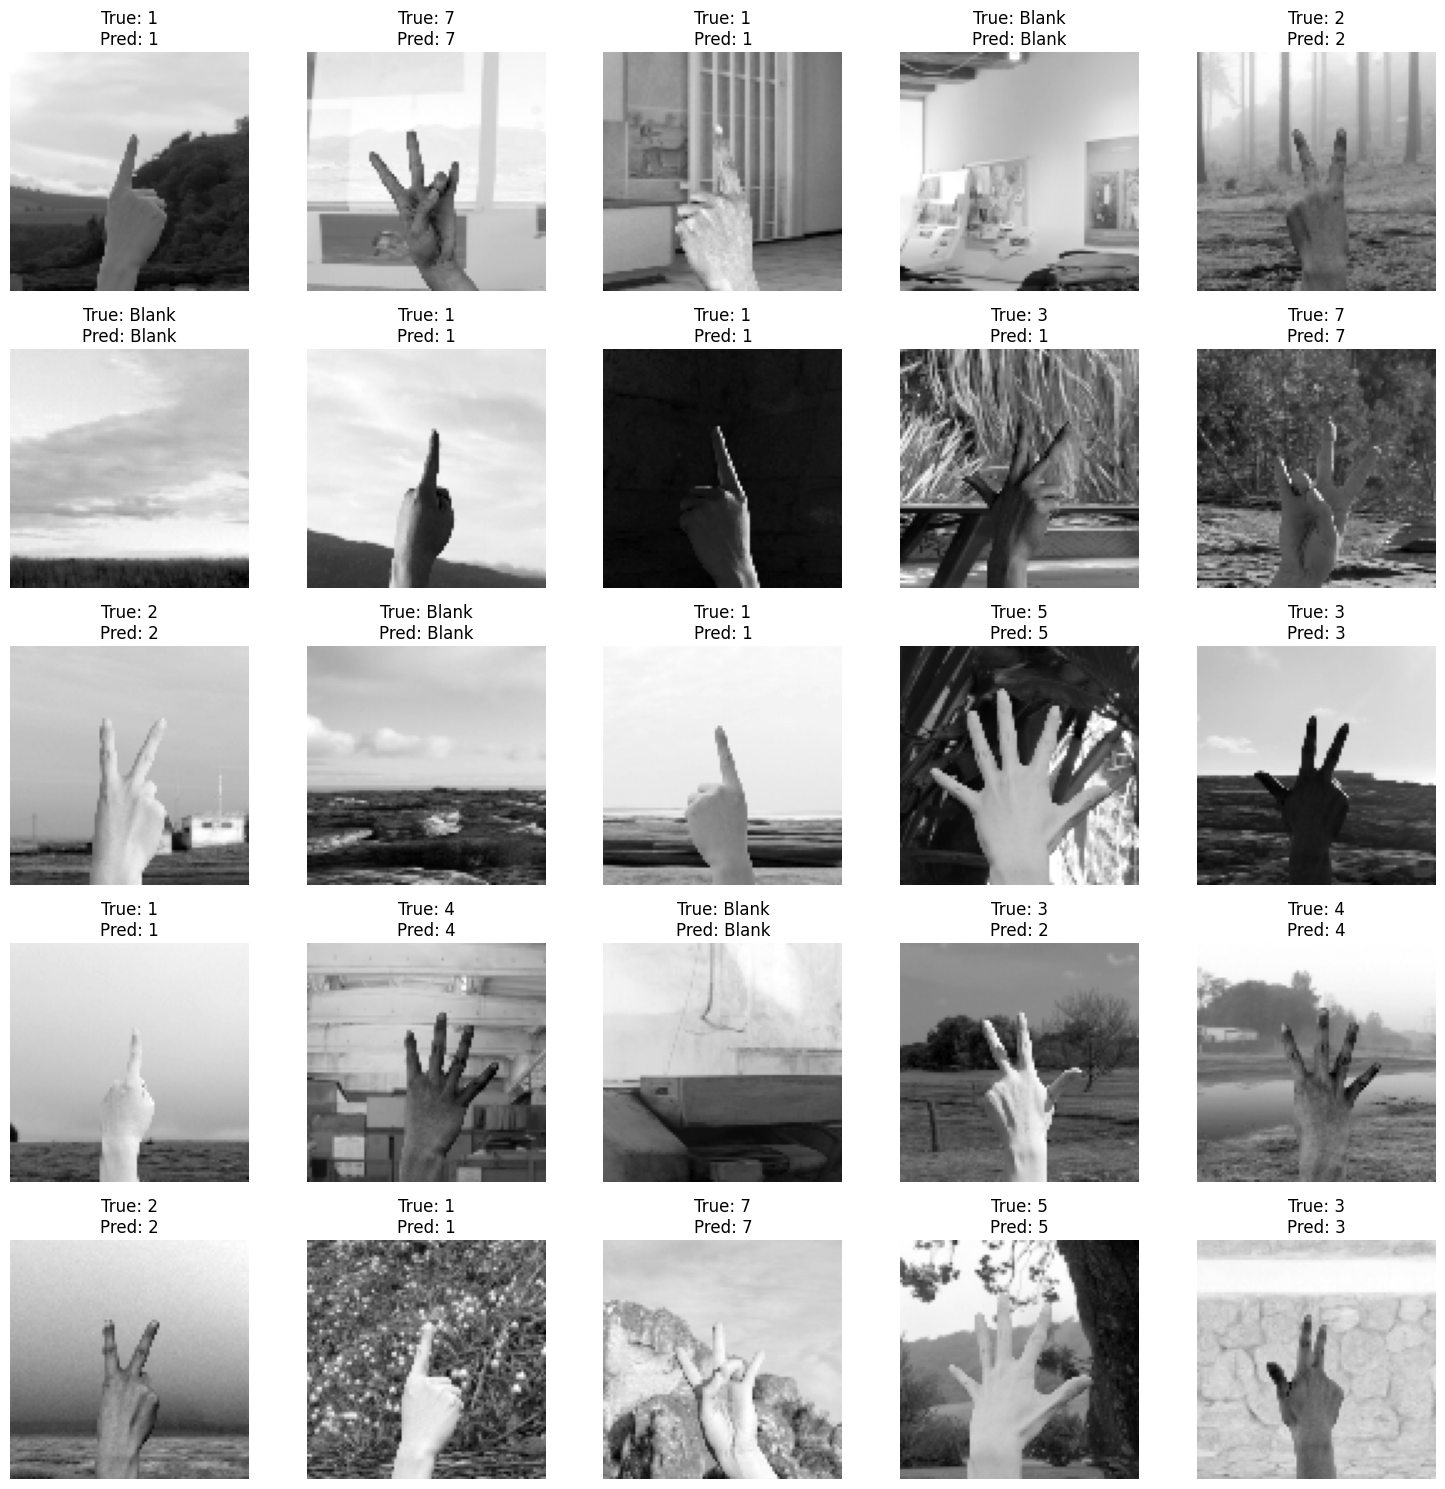

In [101]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

num_images_to_display = 25
plt.figure(figsize=(15, 15))

for i in range(num_images_to_display):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_test[i].reshape(96, 96), cmap='gray')
  plt.title(f"True: {LIST_OF_GESTURES[y_true_classes[i]]}\nPred: {LIST_OF_GESTURES[y_pred_classes[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

# CUANTIZACIÓN

In [102]:
model = tf.keras.models.load_model(MODEL_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_disable_per_channel_quantization_for_dense_layers = True

converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for i in range(len(X_train_augmented)):
        image = X_train_augmented[i].reshape(1, 96, 96, 1)
        yield [image.astype(np.float32)]

converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_model = converter.convert()

with open(QUANTIZED_MODEL_PATH, 'wb') as f: f.write(quantized_tflite_model)
print(f"Modelo cuantizado guardado exitosamente como '{QUANTIZED_MODEL_PATH}'.")

INFO:tensorflow:Assets written to: /tmp/tmpedj78l2y/assets


INFO:tensorflow:Assets written to: /tmp/tmpedj78l2y/assets


Saved artifact at '/tmp/tmpedj78l2y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer_13')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  128104309604176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128104986579344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128104309589200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128105187294672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128104986574928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128107738143184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128105187288912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128107738136656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128105420381008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128105420389456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12810542038408

/home/benja/Documents/University_studies/Proyecto_de_Desarrollo_de_Software_ICC4201/pds3/model_preparation/venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733113739.109214   13393 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1733113739.109230   13393 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-12-02 01:28:59.109376: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpedj78l2y
2024-12-02 01:28:59.110074: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-02 01:28:59.110089: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpedj78l2y
2024-12-02 01:28:59.115450: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-02 01:28:59.148197: I tensorflow/cc/sav

Modelo cuantizado guardado exitosamente como './models/quant_model_v4-3.tflite'.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [103]:
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image):
    image = image.astype(np.uint8)
    image = image.reshape(1, 96, 96, 1)
    return image

def evaluate_model(interpreter, test_images, test_labels):
    total_seen = 0
    num_correct = 0

    for i in range(len(test_images)):
        input_data = preprocess_image(test_images[i])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        if predicted_label == np.argmax(test_labels[i]): num_correct += 1
        total_seen += 1

    accuracy = num_correct / total_seen
    print(f"Precisión del modelo cuantizado: {accuracy:.4f}")

evaluate_model(interpreter, X_test, y_test)

model_size = os.path.getsize(QUANTIZED_MODEL_PATH)
print(f"Tamaño del modelo cuantizado: {model_size / 1024:.2f} KB")  # Mostrar en kilobytes

Precisión del modelo cuantizado: 0.9271
Tamaño del modelo cuantizado: 122.57 KB


## Predicciones del modelo cuantizado

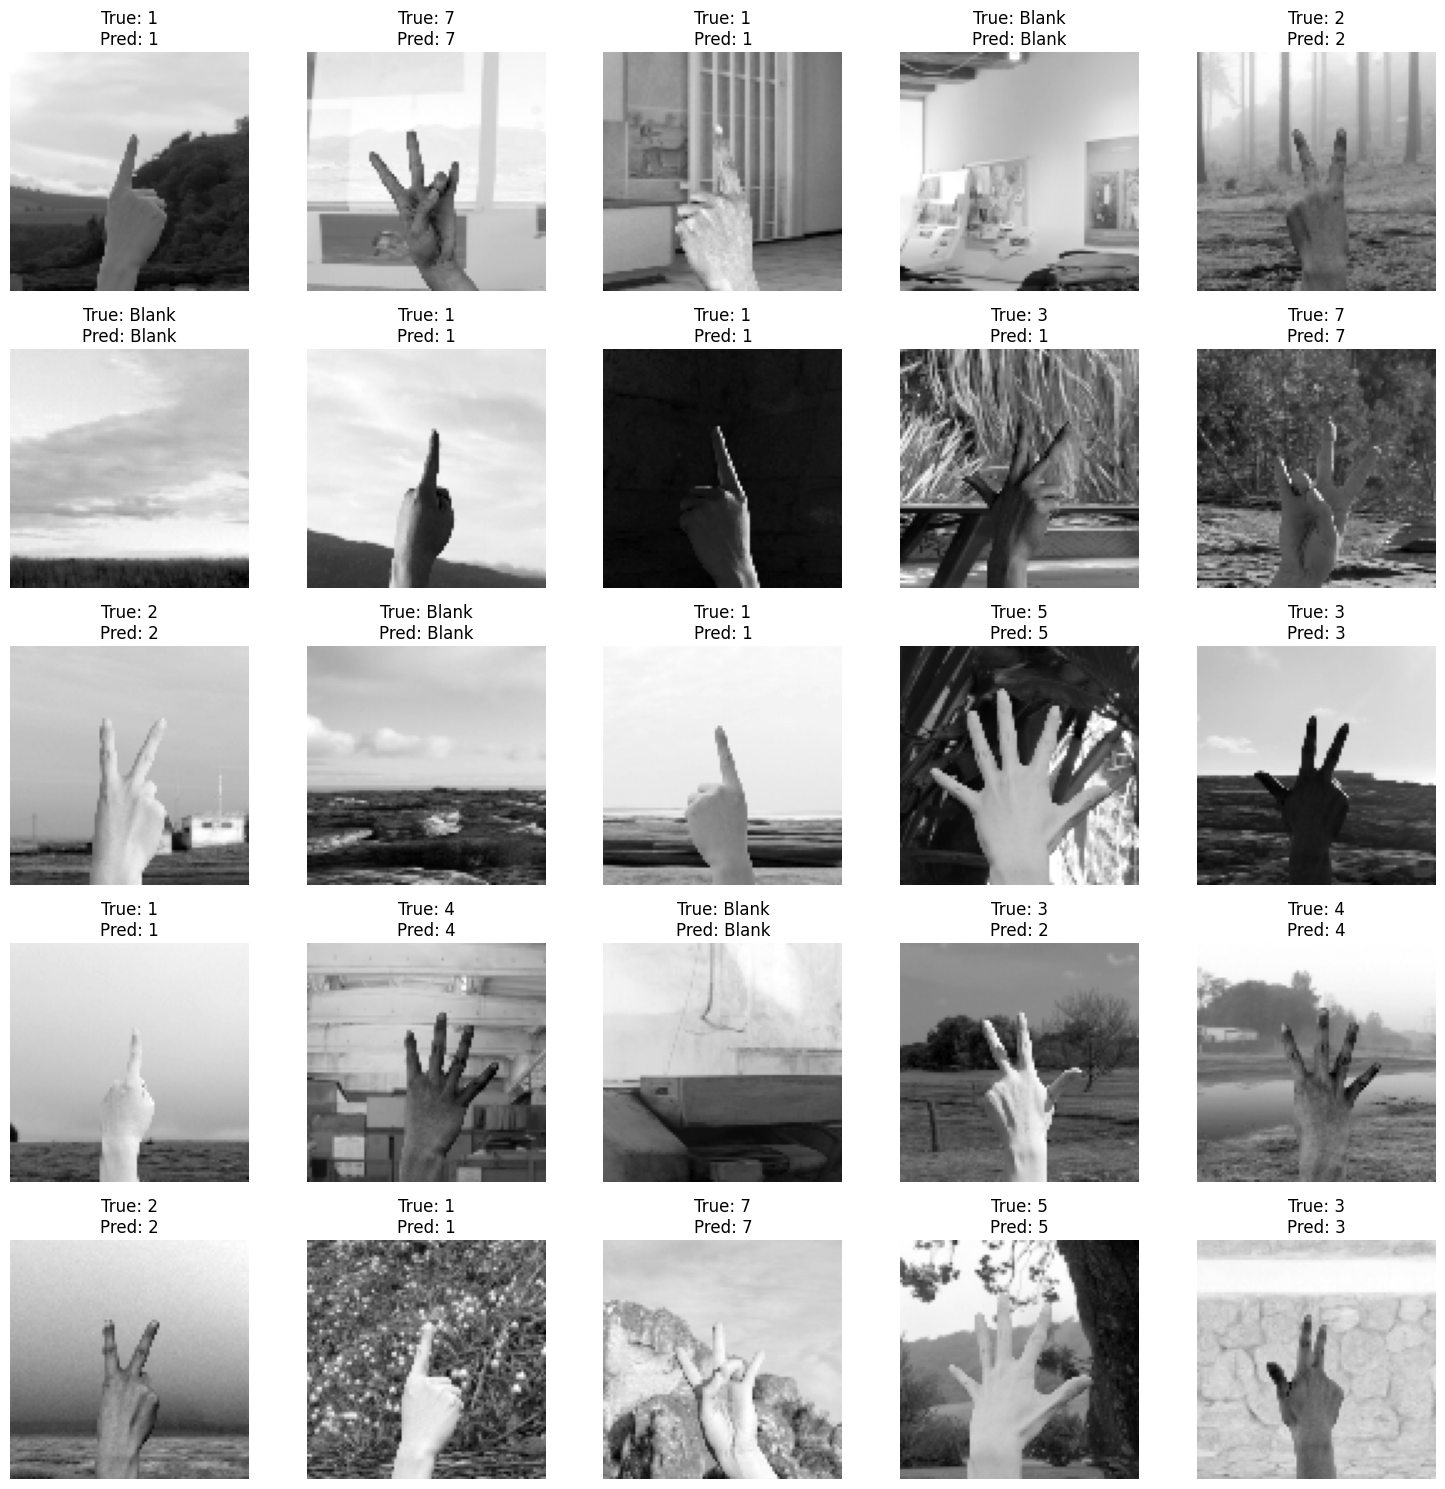

In [104]:
num_images_to_display = 25
plt.figure(figsize=(15, 15))

for i in range(num_images_to_display):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_test[i].reshape(96, 96), cmap='gray')
  plt.title(f"True: {LIST_OF_GESTURES[y_true_classes[i]]}\nPred: {LIST_OF_GESTURES[y_pred_classes[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

## Precision por clase

In [105]:
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image):
    image = image.astype(np.uint8)
    image = image.reshape(1, 96, 96, 1)
    return image

def evaluate_model(interpreter, test_images, test_labels):
    total_seen = 0
    num_correct = 0
    class_correct = np.zeros(test_labels.shape[1])
    class_total = np.zeros(test_labels.shape[1])

    for i in range(len(test_images)):
        input_data = preprocess_image(test_images[i])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        true_label = np.argmax(test_labels[i])
        if predicted_label == true_label:
            num_correct += 1
            class_correct[true_label] += 1
        class_total[true_label] += 1
        total_seen += 1

    accuracy = num_correct / total_seen
    print(f"Precisión del modelo cuantizado: {accuracy:.4f}")

    for i, (correct, total) in enumerate(zip(class_correct, class_total)):
        if total > 0:
            class_accuracy = correct / total
            print(f"Precisión para clase {i}: {class_accuracy:.4f} (Correctos: {int(correct)}, Total: {int(total)})")
        else: print(f"Clase {i} no tiene ejemplos en el conjunto de prueba.")

evaluate_model(interpreter, X_test, y_test)

model_size = os.path.getsize(QUANTIZED_MODEL_PATH)
print(f"Tamaño del modelo cuantizado: {model_size / 1024:.2f} KB")

Precisión del modelo cuantizado: 0.9271
Precisión para clase 0: 0.9461 (Correctos: 193, Total: 204)
Precisión para clase 1: 0.9202 (Correctos: 173, Total: 188)
Precisión para clase 2: 0.8976 (Correctos: 184, Total: 205)
Precisión para clase 3: 0.9347 (Correctos: 186, Total: 199)
Precisión para clase 4: 0.9270 (Correctos: 165, Total: 178)
Precisión para clase 5: 0.9712 (Correctos: 202, Total: 208)
Precisión para clase 6: 0.8945 (Correctos: 195, Total: 218)
Tamaño del modelo cuantizado: 122.57 KB


# HEXADECIMAL

In [106]:
!xxd -i {QUANTIZED_MODEL_PATH} > {HEX_MODEL_PATH}